In [ ]:
import torch
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt
import string 
import os
import re
import time

%matplotlib inline

In [ ]:
# Login to google drive access to load the datasets
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
!unzip '/content/gdrive/MyDrive/Proiect_DL/glove.6B.300d.txt.zip'
# Unzip data in format needed for training the keras model,
# this means each class has a separate folder 

Archive:  /content/gdrive/MyDrive/Proiect_DL/glove.6B.300d.txt.zip
  inflating: glove.6B.300d.txt       


## Import GloVe Embedding as Dictionary

In [ ]:
# create embedding dictionary for GloVe embedding (300d)
embedding_dict = dict()
f = open('glove.6B.300d.txt')
for line in f: 
    values = line.split()
    word = values[0]
    coef = np.asarray(values[1:],dtype='float32')
    embedding_dict[word] = coef # save word as key and coefficients as the value in the dictionary
f.close()

FileNotFoundError: ignored

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

def preprocess(lines):
    processed = [] # preprocess the file
    # lines = file.read().split('\n')
    for line in lines:
        
        words = word_tokenize(line)
        words = [word.lower() for word in words if word.isalnum() and word != 'br']
        text = " ".join(words)
        text = 'bos ' + text + ' eos' # beginning and end tokens for each sentence
        processed.append(text)
    return processed

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
train = pd.read_csv('/content/gdrive/MyDrive/Proiect_DL/Reviews.csv')

In [ ]:
TRAIN = train.drop(['ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', ], axis=1)
TRAIN = TRAIN.dropna()

In [ ]:
lines_train_in = preprocess(TRAIN['Text'].tolist())
lines_train_sum = preprocess(TRAIN['Summary'].tolist())

In [ ]:
TRAIN.head() # display text and summaries

,Id,Summary,Text
0,1,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,Cough Medicine,If you are looking for the secret ingredient i...
4,5,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
print("TRAIN has {} articles".format(TRAIN.shape[0]))

TRAIN has 568427 articles


In [ ]:
TRAIN_in_len = []
TRAIN_sum_len = [] 

# calculate the length of the summary and the input texts
for line in lines_train_in:
    w = 0
    for word in line.split(' '):
        w += 1
    TRAIN_in_len.append(w)
    
for line in lines_train_sum:
    w = 0
    for word in line.split(' '):
        w += 1
    TRAIN_sum_len.append(w)
TRAIN_in_len = np.array(TRAIN_in_len)
TRAIN_sum_len = np.array(TRAIN_sum_len) 

In [ ]:
print("\t\t Min\t 25%\t Avg\t 75%\t Max")
print("\nTRAIN Input\t {}\t{}\t{}\t{}\t{}".format(np.percentile(TRAIN_in_len,0),np.percentile(TRAIN_in_len,25),np.percentile(TRAIN_in_len,50),np.percentile(TRAIN_in_len,75),np.percentile(TRAIN_in_len,100)))
print("TRAIN Summary\t {}\t{}\t{}\t{}\t{}".format(np.percentile(TRAIN_sum_len,0),np.percentile(TRAIN_sum_len,25),np.percentile(TRAIN_sum_len,50),np.percentile(TRAIN_sum_len,75),np.percentile(TRAIN_sum_len,100)))


		 Min	 25%	 Avg	 75%	 Max

TRAIN Input	 5.0	35.0	57.0	98.0	3323.0
TRAIN Summary	 3.0	4.0	5.0	7.0	47.0


In [ ]:
lines_train_inn = TRAIN.iloc[:,2].values
lines_train_summ = TRAIN.iloc[:,1].values

['I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'
 'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".'
 'This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis\' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.'
 ...
 'These stars are sm

In [ ]:
print(TRAIN.iloc[:,2].values[55666])
print(lines_train_in[55666])


My kids really enjoy this cereal probably because it is so sweet. Even sweeter than Honey Nut Cheerios!<br />The image on the box shows each piece coated in nut flakes, far from accurate! You will find a few nut flakes on most of the Os, some with none at all.<br />however, even though the photo isn't accurate, they still taste great. I would like to try some with more nuts as shown though, they might be even better and the additional nuts might better balance the sweetness.<br /><br />The cereal stays crunchy in milk and is very satisfying to eat. They also make a good dry snack and don't leave your fingers sticky.
bos my kids really enjoy this cereal probably because it is so sweet even sweeter than honey nut cheerios the image on the box shows each piece coated in nut flakes far from accurate you will find a few nut flakes on most of the os some with none at however even though the photo is accurate they still taste great i would like to try some with more nuts as shown though they 

(array([3.46994e+05, 1.44214e+05, 4.54720e+04, 1.64760e+04, 7.19100e+03,
        3.42300e+03, 1.77200e+03, 1.15200e+03, 5.36000e+02, 2.99000e+02,
        1.83000e+02, 1.62000e+02, 2.99000e+02, 4.80000e+01, 4.10000e+01,
        3.10000e+01, 2.10000e+01, 2.60000e+01, 2.50000e+01, 1.60000e+01,
        1.00000e+01, 8.00000e+00, 4.00000e+00, 7.00000e+00, 3.00000e+00,
        2.00000e+00, 1.00000e+00, 3.00000e+00, 0.00000e+00, 1.00000e+00,
        3.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 3.00000e+00]),
 array([   5.  ,   71.36,  137.72,  204.08,  270.44,  336.8 ,  403.16,
         469.52,  535.88,  602.24,  668.6 ,  734.96,  801.32,  867.68,
         934.04, 1000.4 , 1066.76, 1133.12, 1199.48, 1265.84, 1332.2 ,
        1398.56, 1464.92, 1531.28, 1597.64, 1664.  , 17

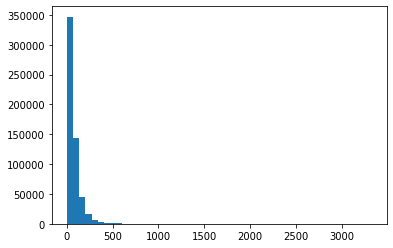

In [ ]:
plt.hist(TRAIN_in_len,bins=50) # plot histogram of the length of input text

(array([6.09200e+04, 1.21804e+05, 1.05605e+05, 8.95740e+04, 6.22760e+04,
        4.51450e+04, 2.92620e+04, 1.95140e+04, 0.00000e+00, 1.29120e+04,
        8.43300e+03, 4.95800e+03, 3.01400e+03, 1.95200e+03, 1.02400e+03,
        6.58000e+02, 0.00000e+00, 4.27000e+02, 2.50000e+02, 2.05000e+02,
        9.20000e+01, 1.00000e+02, 7.70000e+01, 6.70000e+01, 0.00000e+00,
        7.70000e+01, 2.00000e+01, 1.70000e+01, 1.40000e+01, 2.20000e+01,
        2.00000e+00, 3.00000e+00, 2.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([ 3.  ,  3.88,  4.76,  5.64,  6.52,  7.4 ,  8.28,  9.16, 10.04,
        10.92, 11.8 , 12.68, 13.56, 14.44, 15.32, 16.2 , 17.08, 17.96,
        18.84, 19.72, 20.6 , 21.48, 22.36, 23.24, 24.12, 25.  , 25.88,
        26.76, 27.64, 28.52, 29.4 , 30.28, 31.16, 32.04

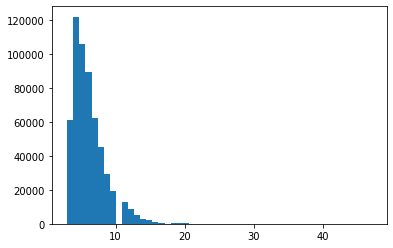

In [ ]:
plt.hist(TRAIN_sum_len,bins=50) # plot histogram of the length of summary

In [ ]:
# remove outliers
a = np.where(np.logical_and(TRAIN_in_len>=20,np.logical_and(TRAIN_in_len<=150,np.logical_and(TRAIN_sum_len>=6,TRAIN_sum_len<=30))))
print(len(a[0]))

230315


In [ ]:
df = pd.DataFrame(list(zip(lines_train_in, lines_train_sum)), 
               columns =['Text', 'Summary']) 

In [ ]:
lines_train_inn   = df.iloc[:,0].values
lines_train_summ  = df.iloc[:,1].values

In [ ]:
data_indices = np.random.randint(len(a[0]),size=230000) # randomly choose 1 million samples
indices = a[0][data_indices]
print(indices)

[102580 198767 479127 ...  62687 386266  84766]


In [ ]:
data_text   = lines_train_inn[indices]
data_sum    = lines_train_summ[indices]
output_len  = TRAIN_sum_len[indices]

In [ ]:
data_text = lines_train_in
data_sum = lines_train_sum
output_len = TRAIN_sum_len

In [ ]:
embedding_dict['pad']

In [ ]:
print(data_sum[33958])

bos healthy and great product eos


In [ ]:
words = [] # create word list for the words in the input text and summaries
for line in data_text:
    for word in line.split(' '):
        words.append(word)

for idx, line in enumerate(data_sum):
    for word in line.split(' '):
        words.append(word)

counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True)
embed_dim = 300
words_found = 0
words_OOV = 0
word2idx = {}
word2idx['<pad>'] = 0
# convert words to index by creating word2idx dictionary
for index, word in enumerate(vocab):
    word2idx[word] = index+1
# create weight embedding matrix for GloVe embedding
weight_embedding = np.zeros([len(vocab)+1,embed_dim],dtype='float32')
for i, word in enumerate(vocab):
    try:
        # if word found in pretrained GloVe embedding dictionary
        weight_embedding[i,:] = embedding_dict[word]
        words_found += 1
    except:
        # if word not found, initialize as random vector
        weight_embedding[i,:] = np.random.normal(scale=0.6, size=[embed_dim,])
        words_OOV += 1

print("{} words found".format(words_found))
print("{} OOV words".format(words_OOV))
idx2word = dict((v,k) for k,v in word2idx.items())
print("{} words in the vocabulary".format(len(vocab)))
        

37339 words found
18055 OOV words
55394 words in the vocabulary


In [ ]:
text_ints = []
summary_ints = []
# convert input text and summaries from words to integers
for each in data_text:
    sentence = []
    for word in each.split():
        sentence.extend([word2idx[word]])
    text_ints.append(sentence)

for each in data_sum:
    sentence = []
    for word in each.split():
        sentence.extend([word2idx[word]])
    summary_ints.append(sentence)

# pad input with 'pad' for sequence length = 50
# pad summaries with 'pad' for sequence length = 14
text_len = 50 
summary_len = 14
text_feature = np.zeros((len(text_ints),text_len),dtype=int)
summary_feature = np.zeros((len(summary_ints),summary_len), dtype=int)
for i, row in enumerate(text_ints):
    text_feature[i,:len(row)] = np.array(row)[:text_len]
for i, row in enumerate(summary_ints):
    summary_feature[i,:len(row)] = np.array(row)[:summary_len]

# train test split
split_frac = 0.8 
split_index = int(len(text_feature)*0.8)
train_text, test_text = text_feature[:split_index],text_feature[split_index:]
train_summary, test_summary = summary_feature[:split_index],summary_feature[split_index:]


print("\t\t\tData Shapes:")
print("Train set: \t\t{}".format(train_text.shape), 
      "\nTest set: \t\t{}".format(test_text.shape))

print("\n\n\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_summary.shape),
      "\nTest set: \t\t{}".format(test_summary.shape))


			Data Shapes:
Train set: 		(184000, 50) 
Test set: 		(46000, 50)


			Feature Shapes:
Train set: 		(184000, 14) 
Test set: 		(46000, 14)


In [ ]:
# save the data an .npz file
np.savez('new_data1M300d.npz',train_text=train_text,test_text=test_text,
         train_summary=train_summary,test_summary=test_summary,
         word2idx = word2idx,idx2word=idx2word, embed_matrix=weight_embedding, output_length = output_len)
print("Data Saved!")

Data Saved!


In [ ]:
import torch
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt
import string 
import os
import re
import queue
%matplotlib inline

# load in the data
print("Loading data")
data = np.load('/content/gdrive/MyDrive/Proiect_DL/new_data1M300d.npz', allow_pickle = True)
train_text = data['train_text']
test_text = data['test_text']
train_summary = data['train_summary']
test_summary = data['test_summary']

word2idx = data['word2idx']
word2idx = dict(word2idx.item())
idx2word = data['idx2word']
idx2word = dict(idx2word.item())

weight_embedding = data['embed_matrix']
weight_embedding = torch.from_numpy(weight_embedding)
output_length = data['output_length']

split_index = int(len(test_text)*0.1)

val_text, test_text  = test_text[:split_index],test_text[split_index:]
val_summary, test_summary  = test_summary[:split_index],test_summary[split_index:]
print('Data Loaded!')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device to run the code on GPU


Loading data
Data Loaded!


# Model code

In [ ]:
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F


def create_emb(weight_matrix, non_trainable=False):
    # create embedding matrix with the pretrained GloVe embedding matrix
    emb_layer = torch.nn.Embedding(weight_matrix.shape[0],weight_matrix.shape[1])
    emb_layer.load_state_dict({'weight': weight_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False # turn off training for the embedding vector
    return emb_layer


class Encoder(nn.Module):
    def __init__(self,kernel_size,filter_size,dropout,num_hidden,layers,weight_matrix,embed_dim,device):
        super(Encoder,self).__init__()
        self.layers = layers
        self.kernel_size = kernel_size
        self.filter_size = filter_size
        self.num_hidden = num_hidden
        self.device = device
        self.embed_dim = embed_dim
        
        # convolutional layers
        self.conv1 = torch.nn.Conv1d(embed_dim,self.filter_size,self.kernel_size[0],stride=1,padding=0)
        self.conv2 = torch.nn.Conv1d(embed_dim,self.filter_size,self.kernel_size[1],stride=1,padding=1)
        self.conv3 = torch.nn.Conv1d(embed_dim,self.filter_size,self.kernel_size[2],stride=1,padding=2)
        self.dropout = torch.nn.Dropout(dropout)
        self.embedding = create_emb(weight_matrix,True)
        # encoder LSTM
        self.lstm = torch.nn.LSTM(input_size = self.embed_dim,hidden_size = self.num_hidden,
                                  num_layers = self.layers,batch_first=True,dropout=0.5,
                                 bidirectional=True)
    def forward(self,x,hidden):
        x = self.embedding(x) # embed the input text
        
        # convolutional layers
        #x1 = torch.tanh(self.dropout(self.conv1(x)))
        #x2 = torch.tanh(self.dropout(self.conv2(x)))
        #x3 = torch.tanh(self.dropout(self.conv3(x)))
        # apply dropout
        lstm_in = self.dropout((x))
        # encoder LSTM
        output,(h_hidden,c_hidden) = self.lstm(lstm_in,hidden)
        # hidden state of the encoder (in case of multilayer LSTM)
        h = torch.cat((h_hidden[-1,:,:],h_hidden[-2,:,:]),1)
        c = torch.cat((c_hidden[-1,:,:],c_hidden[-2,:,:]),1)

        hidden = (h.unsqueeze(0),c.unsqueeze(0))
       
        return output, hidden
    
    def init_hidden(self,batch_size):
        # initialize the hidden state as the zero tensor
        weight = next(self.parameters()).data
        hidden = (weight.new(self.layers*2,batch_size, self.num_hidden).zero_(),
                  weight.new(self.layers*2, batch_size, self.num_hidden).zero_())
        return hidden
        

        

In [ ]:

# code for the attentional decoder
class AttentionDecoder(nn.Module):
    def __init__(self,num_hidden,dropout,vocab_size,layers,weight_matrix,embed_dims,device):
        super(AttentionDecoder,self).__init__()
        self.num_hidden = num_hidden
        self.dropout = dropout
        self.layers = layers
        self.vocab_size = vocab_size
        self.embed_dims = embed_dims
        self.device = device
        self.dropout_layer = torch.nn.Dropout(self.dropout)
        
        # Linear layers for the attention mechanism
        self.V = torch.nn.Linear(self.num_hidden,1)
        
        # layer to get the pointer probability
        self.generator = torch.nn.Linear(2*self.num_hidden+self.embed_dims,1)
        # output layer to vocab
        self.output_layer = torch.nn.Linear(2*self.num_hidden,self.vocab_size)
        # softmax function
        self.softmax = torch.nn.Softmax(dim=1)
        # decoder LSTM
        self.lstm = torch.nn.LSTM(input_size = self.num_hidden+self.embed_dims,hidden_size = self.num_hidden,
                                  num_layers = self.layers,batch_first=True,dropout=0.5,
                                 bidirectional=False)
        # embedding matrix
        self.embedding = create_emb(weight_matrix,True)
        self.sig = torch.nn.Sigmoid()
        self.device = device
        
        
    def forward(self,x,enc_out,hidden,text,batch_size):
        # decoder
        # Decoder Input Shape: [batch_size]
        x = self.embedding(x).unsqueeze(1)
        # Decoder Embedded Shape: [batch_size,1,embed_dim]
        x = self.dropout_layer(x)
        
        # Bahdanau Attention
        dec_a = hidden[0].permute(1,0,2)
        enc_score = self.V(torch.tanh(enc_out + dec_a)) # attention score
        # Attention Score Shape: [batch_size,input_seq_len,1]
        enc_weight = self.softmax(enc_score) # attention weight
        # Attention Weight Shape: [batch_size,input_seq_len,1]
        enc_context = torch.mul(enc_weight,enc_out) # find the context vector
        # Attention Context Shape: [batch_size,input_seq_len,decoder_num_hidden]
        enc_context = enc_context.sum(1)
        # Attention Context Shape: [batch_size,decoder_num_hidden]
        enc_context.unsqueeze_(1)
        # Attention Context Shape: [batch_size,1,decoder_num_hidden]     
        
        d_in = torch.cat((x,enc_context),2)
        # Decoder Input Shape: [batch_size,1,decoder_num_hidden+embed_dims]  
        
        # run the decoder LSTM
        d_output, hidden = self.lstm(d_in,hidden)
        # Decoder Output Shape: [batch_size,1,decoder_num_hidden]  
        # Decoder Hidden Shape: [1,batch_size,decoder_num_hidden]  

        # concatenate output with the encoder context tensor
        output = torch.cat((d_output.squeeze(1),enc_context.squeeze(1)),1)
        # Decoder Output Shape: [batch_size,2*decoder_num_hidden]  
        
        output_generator = torch.cat((enc_context.squeeze(1),d_output.squeeze(1),x.squeeze(1)),1)
        # Generator Input Shape: [batch_size,2*decoder_num_hidden + embed_dims]  
        
        p_gen = self.sig(self.generator(output_generator).squeeze(1))
        
        # pointer-generator
        p_pointer = 1 - p_gen
        pointer_prob = torch.zeros([batch_size,self.vocab_size],device=self.device)
        for i in range(batch_size):
            pointer_prob[i,text[i,:]] = enc_weight[i,:,0] # pointer probability weights are the attention scores
        generator_prob = self.output_layer(output) # output layer to get vocabulary probability
        output_probability = torch.mul(p_pointer.unsqueeze(1),pointer_prob) + torch.mul(p_gen.unsqueeze(1),generator_prob)
        
        return output_probability, hidden
    
    def init_hidden(self,batch_size):
        # initialize the hidden state as the zero tensor
        weight = next(self.parameters()).data
        hidden = (weight.new(self.layers, batch_size, 2*self.num_hidden).zero_(),
                  weight.new(self.layers, batch_size, 2*self.num_hidden).zero_())
        return hidden



In [ ]:
# hyperparameters of the mode
kernel_size = [1, 3, 5] # kernel size for CNN
filter_size = 100 # number of kernels used in CNN
dropout = 0.5 # dropout probability
num_hidden = 256 # number of hidden units in LSTMs
enc_layers = 1 # number of layers in the LSTM encoder
batch_size = 64
vocab_size = len(word2idx) # length of vocab
dec_layers = 1 # number of layers in the LSTM decoder
embed_dims = 300 # embedding dimensions

# create a beam search node to store the running sequences for the beam search decoder
# and records the hidden state associated with the sequence, the probability and the loss
class BeamNode(object):
    def __init__(self,hidden_state,seq,prob,length,loss):
        self.hidden = hidden_state
        self.seq = seq
        self.prob = prob
        self.len = length
        self.loss = loss
        self.s = self.score()
        
    def score(self):
        return self.prob/float(self.len-1+1e-6) # calculates the score of a sequence

class Seq2Seq(nn.Module):
    def __init__(self,kernel_size,filter_size,dropout,num_hidden,enc_layers,weight_embedding,
                vocab_size,dec_layers,embed_dims,device):
        super(Seq2Seq, self).__init__()
        self.vocab_size = vocab_size
        self.device = device
        self.encoder = Encoder(kernel_size,filter_size,dropout,num_hidden,enc_layers,weight_embedding,embed_dims,device)
        self.decoder = AttentionDecoder(2*num_hidden,dropout,vocab_size,dec_layers,weight_embedding,embed_dims,device)
    
    def forward(self,x,target,e_hidden,criterion,batch_size):
        # training the decoder
        loss = 0
        prediction = target[:,0].unsqueeze(1) # records the running sequences generated by the decoder
        enc_output,enc_hidden = self.encoder(x,e_hidden) # run the encoder
        d_hidden = enc_hidden # the decoder input hidden state is the encoder output hidden state
        dec_input = target[:,0] # the decoder input starts of as the 'bos' token
        for t in range(1,target.shape[1]):
            # run the decoder
            logits, d_hidden = self.decoder(dec_input,enc_output,d_hidden,x,batch_size)
            dec_input = target[:,t] # teacher forcing turned on 
            loss += criterion(logits,target[:,t]) # calculate the loss function
            # add to get the running prediction output by the decoder
            prediction = torch.cat((prediction,torch.argmax(logits,dim=0).unsqueeze(1)),0)
        return loss, prediction
    
    def inference_greedy(self,x,target,e_hidden,criterion,batch_size):
        loss = 0
        prediction = target[:,0].unsqueeze(1) # records the running sequences generated by the decoder
        enc_output,enc_hidden = self.encoder(x,e_hidden) # run the encoder
        d_hidden = enc_hidden # the decoder input hidden state is the encoder output hidden state
        dec_input = target[:,0] # the decoder input starts of as the 'bos' token
        for t in range(1,target.shape[1]):
            # run the decoder
            logits, d_hidden = self.decoder(dec_input,enc_output,d_hidden,x,batch_size)
            # the input to the decoder at the next step is the argument with the largest probability
            dec_input = torch.argmax(logits,dim=1)
            loss += criterion(logits,target[:,t]) # calculate the loss
            # add to get the running prediction output by the decoder
            prediction = torch.cat((prediction,torch.argmax(logits,dim=0).unsqueeze(1)),0)
        return loss, prediction
    
    def inference_beam(self,x,target,e_hidden,criterion,beam_width,batch_size):
        decoded = [] 
        losses = 0
        enc_output,enc_hidden = self.encoder(x,e_hidden) # run the encoder
        for i in range(batch_size):
            # for each sentence in the batch
            prediction = target[i,0].view([1]).unsqueeze(1) # running prediction tensor
            dec_hidden = enc_hidden[0].permute(1,0,2)[i,:,:].unsqueeze(0)
            dec_input = target[i,0].view([1])
            d_hidden = (enc_hidden[0][:,i,:].unsqueeze(0),enc_hidden[1][:,i,:].unsqueeze(0))
            first_node = BeamNode(d_hidden,dec_input,0,1,0) # the first node is the 'bos' token
            nodes = queue.PriorityQueue(maxsize=beam_width) # create a priority queue to store the beam search nodes
            nodes.put((-first_node.score(),first_node)) # place the first node in the queue
            for t in range(1,target.shape[1]):
                # go through each of the words in the target
                candidatenodes = [] # stores the candidate nodes for a one step look ahead
                candidatescore = [] # stores the candidate scores for a one step look ahead
                donenodes = [] # stores the sequences that have been completed - contain 'eos' token

                # This runs through the 10 sequences in the queue and does a one step look ahead
                # to find 100 possible candidates. The top 10 candidates are then added to the queue
                # and the next word of the decoder is computed
                
                for _ in range(nodes.qsize()):
                    # for each sequence in the queue
                    try:
                      sc,nodex = nodes.get() # get the node from the queue
                      seq = nodex.seq.view([-1,1]) # the sequence in the node
                      dec_input = seq[-1,:] # the last word of the sequence is the input to the decoder
                      hidden = nodex.hidden # the hidden state associated with the sequence
                      d_hidden = (hidden[0],hidden[1]) # the hidden state of the decoder

                      if dec_input == word2idx['eos']:
                          # if the sequence is completed, then it is added to 'donenodes' list
                          donenodes.append((sc,nodex))
                      else:
                          # run the decoder
                          logits, d_hidden = self.decoder(dec_input,enc_output[i,:,:].unsqueeze(0),d_hidden,x,batch_size=1)
                          # calculate the loss
                          loss = criterion(logits,target[i,t].view([1]))
                          # pick the top 10 logits values
                          log_p, index = torch.topk(logits,beam_width)
                          for k in range(beam_width):
                              # create a beam node for each of the top 10 to get the candidate nodes
                              node = BeamNode(d_hidden, torch.cat([nodex.seq,index[0,k].unsqueeze(0)]),nodex.prob+log_p[0][k],nodex.len+1,nodex.loss+loss)
                              score = -node.score()
                              candidatenodes.append([score,node])
                    except:
                      pass 
                    
                # put the finished sequences first in the queue first and then fill with candidate nodes
                for score,n in donenodes:
                    nodes.put((score,n))
                for score,n in candidatenodes[nodes.qsize():beam_width]:
                    nodes.put((score,n))
            _,output_node = nodes.get()
            
            # the output of the beam search decoder is the sequence with the lowest score
            decoded.append(output_node.seq)
            losses+=output_node.loss
            del nodes
        return losses/batch_size,decoded
    

In [ ]:
def get_batches(x, y,batch_size=100):
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

# Train Code

In [ ]:
epochs = 5
learning_rate = 0.001
# initialize model
model = Seq2Seq(kernel_size,filter_size,dropout,num_hidden,enc_layers,weight_embedding,
                vocab_size,dec_layers,embed_dims,device).to(device)
# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
# cross entropy loss function with the padding ignored
criterion = nn.CrossEntropyLoss(ignore_index=0)
counter = 0
loss = []
beam_width = 10 # beam search width is 10

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
model.load_state_dict(torch.load('/content/gdrive/MyDrive/Proiect_DL/model_cnn.pt'))
loss_history = []

In [ ]:
for e in range(epochs):
    start_time = time.time() # start timer
    # shuffle the data at the beginning of epoch
    p = np.random.permutation(train_summary.shape[0])
    train_text = train_text[p,:]
    train_summary = train_summary[p,:]
    # initialize encoder initial hidden state
    e_hidden = model.encoder.init_hidden(batch_size)
    
    for x,y in get_batches(train_text,train_summary,batch_size):
        model.train()
        # convert inputs to PyTorch tensor
        x = torch.from_numpy(x).to(device)
        y = torch.from_numpy(y).to(device)
        
        e_hidden = tuple([each.data for each in e_hidden])
        optimizer.zero_grad() # zero the gradients of the model
        # train the model
        l,prediction = model(x,y,e_hidden,criterion,batch_size)
        loss.append(l.item()) # add loss function
        l.backward()
        nn.utils.clip_grad_norm_(model.parameters(),2) # gradient clip with norm = 2
        optimizer.step() # step the optimizer to apply the gradient
        
        if counter%50 == 0:
            print("Epoch: {}/{} ".format(e+1, epochs),
                      "\tStep: {} ".format(counter),
                      "\tLoss: {:.4f} ".format(l.item()))
        counter += 1
    print("Time to train epoch: {0} s".format(time.time()-start_time))

Epoch: 1/5  	Step: 0  	Loss: 23.2383 
Epoch: 1/5  	Step: 50  	Loss: 16.8852 
Epoch: 1/5  	Step: 100  	Loss: 18.8596 
Epoch: 1/5  	Step: 150  	Loss: 17.0171 
Epoch: 1/5  	Step: 200  	Loss: 21.3989 
Epoch: 1/5  	Step: 250  	Loss: 23.7553 
Epoch: 1/5  	Step: 300  	Loss: 21.8640 
Epoch: 1/5  	Step: 350  	Loss: 21.7581 
Epoch: 1/5  	Step: 400  	Loss: 19.3116 
Epoch: 1/5  	Step: 450  	Loss: 21.6264 
Epoch: 1/5  	Step: 500  	Loss: 21.0058 
Epoch: 1/5  	Step: 550  	Loss: 20.8320 
Epoch: 1/5  	Step: 600  	Loss: 19.8451 
Epoch: 1/5  	Step: 650  	Loss: 27.6211 
Epoch: 1/5  	Step: 700  	Loss: 20.6362 
Epoch: 1/5  	Step: 750  	Loss: 26.2264 
Epoch: 1/5  	Step: 800  	Loss: 23.3520 
Epoch: 1/5  	Step: 850  	Loss: 23.2617 
Epoch: 1/5  	Step: 900  	Loss: 21.9027 
Epoch: 1/5  	Step: 950  	Loss: 21.3479 
Epoch: 1/5  	Step: 1000  	Loss: 24.4694 
Epoch: 1/5  	Step: 1050  	Loss: 25.5245 
Epoch: 1/5  	Step: 1100  	Loss: 19.2045 
Epoch: 1/5  	Step: 1150  	Loss: 24.4371 
Epoch: 1/5  	Step: 1200  	Loss: 22.8021

In [ ]:
loss_history +=  loss
print(loss_history)

[141.94430541992188, 140.80812072753906, 139.53411865234375, 136.81541442871094, 107.82543182373047, 112.9324722290039, 76.89036560058594, 75.82717895507812, 80.359375, 96.73359680175781, 85.56800842285156, 92.5725326538086, 80.62416076660156, 66.21697235107422, 80.10881805419922, 75.71613311767578, 60.939754486083984, 68.62248992919922, 69.75409698486328, 92.14048767089844, 87.64278411865234, 72.03993225097656, 76.5732650756836, 70.30184173583984, 78.97052001953125, 83.2304916381836, 77.92742919921875, 80.2802734375, 72.54320526123047, 74.65744018554688, 56.55583572387695, 84.65293884277344, 79.78913116455078, 81.9104232788086, 83.81285858154297, 83.1772232055664, 73.22856140136719, 64.52442169189453, 70.73229217529297, 76.32606506347656, 73.85335540771484, 85.83935546875, 58.703025817871094, 81.7684326171875, 71.23506927490234, 67.13523864746094, 73.66301727294922, 82.92567443847656, 62.58418273925781, 74.24620819091797, 72.51773071289062, 75.90740203857422, 73.8292465209961, 71.9837

In [ ]:
# beam search decoder
with torch.no_grad():
    beam_time = time.time() # start timer
    loss_beam = [] 
    beam_predict = [] # save beam search decoder outputs
    summary_validation = [] # save validation target summaries
    text_validation = [] # save validation input text
    model.eval()
    # initialize the encoder hidden state
    val_hidden = model.encoder.init_hidden(batch_size)
    for x_val, y_val in get_batches(val_text,val_summary,batch_size):
        # convert data to PyTorch tensor
        x_val = torch.from_numpy(x_val).to(device)
        y_val = torch.from_numpy(y_val).to(device)
        val_hidden = tuple([each.data for each in val_hidden])
        # run the beam search decoder
        val_loss, prediction = model.inference_beam(x_val, y_val, val_hidden, criterion, beam_width, batch_size=64)
        loss_beam.append(val_loss.item())
        beam_predict.append(prediction)
        summary_validation.append(y_val)
        text_validation.append(x_val)
    model.train()
    print("Beam Test: {0} s".format(time.time()-beam_time))
    print("Val Beam Search Loss: {:.4f}".format(np.mean(loss_beam)))


Beam Test: 1141.398203611374 s
Val Beam Search Loss: 33.8519


In [ ]:
# print(text_validation[0])
# print(summary_validation[0])
# print(beam_predict[0])
print(loss_beam)


[30.832120895385742, 33.680259704589844, 36.0910530090332, 33.5916748046875, 35.47277069091797, 30.349720001220703, 30.896089553833008, 34.352149963378906, 34.659523010253906, 36.08369445800781, 33.25849533081055, 32.84959411621094, 34.18021011352539, 32.72153854370117, 33.72119903564453, 34.96760559082031, 30.36574935913086, 34.75667190551758, 37.654170989990234, 33.99497985839844, 32.06047821044922, 32.37260055541992, 34.3450927734375, 34.246559143066406, 33.218624114990234, 32.285118103027344, 34.73385238647461, 33.11829376220703, 34.76516342163086, 34.168373107910156, 34.98539352416992, 32.410884857177734, 35.671443939208984, 32.80603790283203, 32.79864501953125, 36.00944900512695, 38.14274978637695, 33.84666061401367, 33.35238265991211, 31.357563018798828, 34.8306770324707, 31.2299861907959, 37.549076080322266, 35.666648864746094, 38.305660247802734, 33.91606903076172, 32.47078323364258, 32.82387924194336, 35.7008171081543, 33.26061248779297, 37.87160110473633, 28.57151985168457, 

In [ ]:
# Run the greedy decoder
with torch.no_grad():
    greedy_time = time.time() # start timer
    loss_greedy = []
    greedy_predict = []
    model.eval()
    # initialize the encoder hidden states
    val_hidden = model.encoder.init_hidden(batch_size=64)
    for x_val, y_val in get_batches(val_text,val_summary,batch_size=64):
        # convert data to PyTorch tensor
        x_val = torch.from_numpy(x_val).to(device) 
        y_val = torch.from_numpy(y_val).to(device)
        val_hidden = tuple([each.data for each in val_hidden])
        # run the greedy decoder
        val_loss, prediction = model.inference_greedy(x_val,y_val,val_hidden,criterion,batch_size=64)
        loss_greedy.append(val_loss.item())
        greedy_predict.append(prediction)
        
    model.train()
    print("Greedy Test: {0} s".format(time.time()-greedy_time))
    print("Val Greedy Loss: {:.4f}".format(np.mean(loss_greedy)))
    

Greedy Test: 4.290465831756592 s
Val Greedy Loss: 76.3284


In [ ]:
np.savez('AbSumOut.npz',greedy_predict=greedy_predict,beam_predict=beam_predict, text_validation=text_validation,summary_validation=summary_validation,idx2word=idx2word)
print("Data Saved!")

Data Saved!


In [ ]:
print()

In [ ]:
# save the results of the beam search inference method
beam = []
file = open("beam.txt","w")
for i in beam_predict:
    for p in i:
        array = torch.Tensor.cpu(p).numpy()
        beam_string = ''
        for q in array:
            beam_string += idx2word[q] + ' ' 
        file.write(beam_string+'\n')
        beam.append(beam_string)
file.close()

# save the results of the beam search inference method
# greed = []
# file = open("greed.txt","w")
# for i in greedy_predict:
#     for p in i:
#         array = torch.Tensor.cpu(p).numpy()
#         beam_string = ''
#         for q in array:
#             beam_string += idx2word[q] + ' ' 
#         file.write(beam_string+'\n')
#         greed.append(beam_string)
# file.close()

# save the validation summaries for the input text used in the beam search decoder
summary = []
file = open("validation_summary.txt","w")
for i in summary_validation:
    for p in i:
        array = torch.Tensor.cpu(p).numpy()
        summary_string = ''
        for q in array:
            if q != 0:
                summary_string += idx2word[q] + ' ' 
        file.write(summary_string+'\n')
        summary.append(summary_string)
file.close()

# Save the validation input text as a .txt file
text = []
file = open("validation_text.txt","w")
for i in text_validation:
    for p in i:
        array = torch.Tensor.cpu(p).numpy()
        text_string = ''
        for q in array:
            if q != 0:
                text_string += idx2word[q] + ' ' 
        file.write(text_string+'\n')
        text.append(text_string)
file.close()

In [ ]:
## Plotting the error function
import matplotlib.pyplot as plt
import pylab
%matplotlib inline

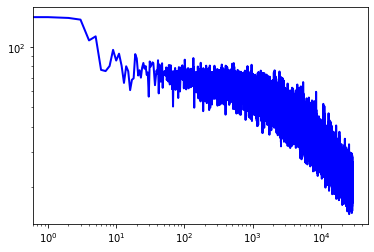

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(loss, color='blue', lw=2)
ax.set_yscale('log')
ax.set_xscale('log')

pylab.show()

In [ ]:
plt.plot(curent_train_loss)
plt.plot(curent_val_loss)
plt.title('Model Loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
!pip install rouge


In [ ]:
from rouge import FilesRouge

files_rouge = FilesRouge()
scores = files_rouge.get_scores('/content/validation_summary.txt', '/content/beam.txt')
#print(scores)

scores = files_rouge.get_scores('/content/validation_summary.txt', '/content/beam.txt', avg=True)
print(scores)


{'rouge-1': {'f': 0.45563377942264865, 'p': 0.4289880228095386, 'r': 0.49951119767360314}, 'rouge-2': {'f': 0.14161053303105825, 'p': 0.13312557332143593, 'r': 0.15579553711155852}, 'rouge-l': {'f': 0.46246583852546574, 'p': 0.4294041974994803, 'r': 0.5177496322632731}}


In [ ]:
from rouge import Rouge 

hypothesis = "bos great chips but company eos "

reference = "bos great chips great company eos"

rouge = Rouge()
scores = rouge.get_scores(hypothesis, reference)
print(scores)

[{'rouge-1': {'f': 0.999999995, 'p': 1.0, 'r': 1.0}, 'rouge-2': {'f': 0.999999995, 'p': 1.0, 'r': 1.0}, 'rouge-l': {'f': 0.999999995, 'p': 1.0, 'r': 1.0}}]
